## First things first
* Click **File -> Save a copy in Drive** and click **Open in new tab** in the pop-up window to save your progress in Google Drive.
* Click **Runtime -> Change runtime type** and select **GPU** in Hardware accelerator box to enable faster GPU training.

#**Final Project for Coursera's 'How to Win a Data Science Competition'**
April, 2020

Andreas Theodoulou and Michael Gaidis

(Competition Info last updated:  3 years ago)

##**About this Competition**

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

Evaluation: root mean squared error (RMSE). True target values are clipped into [0,20] range.

.

##**File descriptions**

***sales_train.csv*** - the training set. Daily historical data from January 2013 to October 2015.

***test.csv*** - the test set. You need to forecast the sales for these shops and products for November 2015.

***sample_submission.csv*** - a sample submission file in the correct format.

***items.csv*** - supplemental information about the items/products.

***item_categories.csv***  - supplemental information about the items categories.

***shops.csv***- supplemental information about the shops.

.

##**Data fields**

***ID*** - an Id that represents a (Shop, Item) tuple within the test set

***shop_id*** - unique identifier of a shop

***item_id*** - unique identifier of a product

***item_category_id*** - unique identifier of item category

***item_cnt_day*** - number of products sold. You are predicting a monthly amount of this measure

***item_price*** - current price of an item

***date*** - date in format dd/mm/yyyy

***date_block_num*** - a consecutive month number. January 2013 is 0, February 2013 is 1,..., October 2015 is 33

***item_name*** - name of item

***shop_name*** - name of shop

***item_category_name*** - name of item category

#Load Files
Load competition data files and import helpful custom code libraries from shared GitHub repository

In [0]:
# GitHub file location info
git_hub_url = "https://raw.githubusercontent.com/migai/"
repo_name = 'Kag/'
branch_name = 'master/'
base_url = git_hub_url + repo_name + branch_name

# List of the data files (path relative to GitHub branch), to be loaded into pandas DataFrames
data_files = [  "readonly/final_project_data/items.csv",
                "readonly/final_project_data/item_categories.csv",
                "readonly/final_project_data/shops.csv",
                "readonly/final_project_data/sample_submission.csv.gz",
                "readonly/final_project_data/sales_train.csv.gz",
                "readonly/final_project_data/test.csv.gz"  ]

# List of helper code files, to be loaded into Colab and available for python import
code_files = [  "kaggle_utils_at_mg.py"]

In [31]:
import pandas as pd
import os

def xfer_github_to_colab(path):
    filename = path.rsplit("/")[-1]
    os.system("wget " + base_url + "{} -O {}".format(path, filename))
    print(base_url + path + " ---> loaded into ---> " + filename)
    return filename

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    print("Loading Files from GitHub to Colab\n")

    # Loop to load the above data files into appropriately-named pandas DataFrames
    for path_name in data_files:
      filename = xfer_github_to_colab(path_name)
      data_frame_name = path_name.rsplit("/")[-1].split(".")[0]
      exec(data_frame_name + " = pd.read_csv(filename)")
      print("Data Frame: " + data_frame_name)
      print(eval(data_frame_name).head(2))
      print("\n")


    # to load a code (".py") file into Colab, first shred to make sure you aren't using an old version
    for path_name in code_files:
      filename = path_name.rsplit("/")[-1]
      ! shred -u {filename}
      filename = xfer_github_to_colab(path_name)

Loading Files from GitHub to Colab

https://raw.githubusercontent.com/migai/Kag/master/readonly/final_project_data/items.csv ---> loaded into ---> items.csv
Data Frame: items
                                           item_name  item_id  item_category_id
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0                40
1  !ABBYY FineReader 12 Professional Edition Full...        1                76


https://raw.githubusercontent.com/migai/Kag/master/readonly/final_project_data/item_categories.csv ---> loaded into ---> item_categories.csv
Data Frame: item_categories
        item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1


https://raw.githubusercontent.com/migai/Kag/master/readonly/final_project_data/shops.csv ---> loaded into ---> shops.csv
Data Frame: shops
                       shop_name  shop_id
0  !Якутск Орджоникидзе, 56 фран        0
1  !Якутск ТЦ "Центральный" фран        1


https://ra

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
import time
from sklearn.linear_model import LinearRegression
#from catboost import CatBoostRegressor
import pickle

#from catboost import CatBoostRegressor 

# **Data Preparation**

*   Make data table monthly from daily (is there any point in using the daily data in more advanced modelling versions? Probably just to create more relevant monthly related features (e.g. mean/std or any other type) rather than keeping the format of the table daily)
*   To do: Merge item_category_id as a feature




Make table monthly

In [33]:
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = sales_train[sales_train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
print("monthly table is")
matrix.head()


monthly table is


,date_block_num,shop_id,item_id
139255,0,0,19
141495,0,0,27
144968,0,0,28
142661,0,0,29
138947,0,0,32


In [34]:
#Concatenate item category on item item_id's
sales_train = pd.DataFrame.merge(sales_train,items[['item_category_id', 'item_id']],on='item_id')
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,02.01.2013,0,59,22154,999.0,1.0,37
1,23.01.2013,0,24,22154,999.0,1.0,37
2,20.01.2013,0,27,22154,999.0,1.0,37
3,02.01.2013,0,25,22154,999.0,1.0,37
4,03.01.2013,0,25,22154,999.0,1.0,37


In [35]:
ts = time.time()
monthly_sales = sales_train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day': ['sum']})
monthly_sales.columns = ['item_cnt_month']
monthly_sales.reset_index(inplace=True)

matrix = pd.merge(matrix, monthly_sales, on=cols, how='left') #note this merge used to be how = 'left' at first (at first results of GBT) - in case anything doesn't work in the future keep in mind this was changed - might be root of a problem
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,19,0.0
1,0,0,27,0.0
2,0,0,28,0.0
3,0,0,29,0.0
4,0,0,32,6.0


In [36]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month
matrix['ID'] = matrix['ID'].astype(np.int32)

matrix.tail()

,date_block_num,shop_id,item_id,item_cnt_month,ID
11128045,34,45,18454,0.0,214195
11128046,34,45,16188,0.0,214196
11128047,34,45,15757,0.0,214197
11128048,34,45,19648,0.0,214198
11128049,34,45,969,0.0,214199


In [37]:
#Concatenate item category on item item_id's
matrix = pd.DataFrame.merge(matrix,items[['item_category_id', 'item_id']],on='item_id')
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID,item_category_id
0,0,0,19,0.0,0,40
1,0,1,19,0.0,0,40
2,0,2,19,0.0,0,40
3,0,3,19,0.0,0,40
4,0,4,19,0.0,0,40


In [38]:
df = matrix[matrix['date_block_num'] == 34]
df1 = df.describe(include = 'all')

df1.loc['dtype'] = df.dtypes
df1.loc['size'] = len(df)
df1.loc['% count'] = df.isnull().mean()
df1.loc['%count 0'] = df.apply(lambda col: (col.count() - np.count_nonzero(col)))
df1

,date_block_num,shop_id,item_id,item_cnt_month,ID,item_category_id
count,214200,214200,214200,214200,214200,214200
mean,34,31.6429,11019.4,0,107100,46.3096
std,0,17.5619,6252.64,0,61834.4,16.7166
min,34,2,30,0,0,0
25%,34,16,5381.5,0,53549.8,37
50%,34,34.5,11203,0,107100,43
75%,34,47,16071.5,0,160649,58
max,34,59,22167,0,214199,83
dtype,int8,int8,int16,float16,int32,int64
size,214200,214200,214200,214200,214200,214200


In [39]:
#Count of monthly data points for each category
#item_id category
matrix[matrix['date_block_num'] <= 6].groupby('item_id').agg({'item_id': 'count'}).describe()
#shop_id category
matrix[matrix['date_block_num'] <= 6].groupby(['shop_id']).agg({'shop_id': 'count'}).describe()
#shop_id & item_id category
matrix[matrix['date_block_num'] <= 6].groupby(['shop_id', 'item_id']).agg({'shop_id': 'count'}).describe()

,shop_id
count,605635.000000
mean,4.374480
std,2.296949
min,1.000000
25%,2.000000
50%,5.000000
75%,7.000000
max,7.000000


In [40]:
sales_train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['count']}).describe()

,item_cnt_day
,count
count,1.609124e+06
mean,1.824501e+00
std,1.981633e+00
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,2.000000e+00
max,3.100000e+01


In [41]:
#Basic demonstration of feature generation to follow
#mean of a item price or item count for the month with respect to items (will also do with respect to shops later)
group = sales_train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean'],
                                                               'item_cnt_day': ['mean']})
group.columns = ['price_mean_by_item', 'sales_mean_by_item']
group

price_mean_by_item  sales_mean_by_item
date_block_num item_id                                        
0              19                28.000000            1.000000
               27              2325.000000            1.000000
               28               549.000000            1.000000
               29              2397.500000            0.666667
               32               338.110349            1.328889
...                                    ...                 ...
33             22162            349.000000            1.000000
               22163            162.698400            1.040000
               22164            549.000000            1.000000
               22166            150.000000            1.833333
               22167            293.098437            1.156250

[233912 rows x 2 columns]

### **Featue Generation/Engineering**

Time series features
*   Statistics of previous months (e.g. mean of item_price for a specific item/shop in previous months)
*   Trends of previous months - rate of change of the above statistics based features (e.g. rate of change of mean item_price from today to the past 3 months for a specific shop/item)




In [0]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in range(len(lags)):
        shifted_df = tmp.copy()
        shifted_df.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(lags[i])]
        shifted_df['date_block_num'] += lags[i]
        if i == 0:
          shifted_df_merged = shifted_df
        else:
          shifted_df_merged = pd.merge(shifted_df_merged, shifted_df, on=['date_block_num','shop_id','item_id'], how='left')
    return shifted_df_merged

import numpy as np
def downcast_df(data):
  for col in data.columns:
    col_type = data[col].dtype
    if col_type == int:
      data[col] = data[col].astype(np.int8)
    elif col_type == float:
      data[col] = data[col].astype(np.float16)
    else:
      pass
  return data

Stage 1: Statistics based features

> 1st step: Compute their Values


In [43]:
#mean, std, and median of item price at specific date_block_num and item_id
monthly_sales_per_item = sales_train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean', 'std', 'median'],
                                                               'item_cnt_day': ['mean', 'std', 'median']
                                                               })
monthly_sales_per_item.columns = ['price_mean_by_item', 'price_std_by_item', 'price_median_by_item',
                 'sales_mean_by_item', 'sales_std_by_item', 'sales_median_by_item']
monthly_sales_per_item.reset_index(inplace=True)
matrix = pd.merge(matrix, monthly_sales_per_item, on=['date_block_num','item_id'], how='left')

#mean, std, and median of item price at specific date_block_num and shop_id
monthly_sales_per_shop = sales_train.groupby(['date_block_num','shop_id']).agg({'item_price': ['mean', 'std', 'median'],
                                                               'item_cnt_day': ['mean', 'std', 'median']})
monthly_sales_per_shop.columns = ['price_mean_by_shop', 'price_std_by_shop', 'price_median_by_shop',
                 'sales_mean_by_shop', 'sales_std_by_shop', 'sales_median_by_shop']
monthly_sales_per_shop.reset_index(inplace=True)
matrix = pd.merge(matrix, monthly_sales_per_shop, on=['date_block_num','shop_id'], how='left')

#mean, std and median of item price at specific date_block_num and item_category
monthly_sales_per_item_category = sales_train.groupby(['date_block_num','item_category_id']).agg({'item_price': ['mean', 'std', 'median'],
                                                               'item_cnt_day': ['mean', 'std', 'median']})
monthly_sales_per_item_category.columns = ['price_mean_by_item_category', 'price_std_by_item_category', 'price_median_by_item_category',
                 'sales_mean_by_item_category', 'sales_std_by_item_category', 'sales_median_by_item_category']

monthly_sales_per_item_category.reset_index(inplace=True)
matrix = pd.merge(matrix, monthly_sales_per_item_category, on=['date_block_num','item_category_id'], how='left')

matrix = downcast_df(matrix)

matrix

,date_block_num,shop_id,item_id,item_cnt_month,ID,item_category_id,price_mean_by_item,price_std_by_item,price_median_by_item,sales_mean_by_item,sales_std_by_item,sales_median_by_item,price_mean_by_shop,price_std_by_shop,price_median_by_shop,sales_mean_by_shop,sales_std_by_shop,sales_median_by_shop,price_mean_by_item_category,price_std_by_item_category,price_median_by_item_category,sales_mean_by_item_category,sales_std_by_item_category,sales_median_by_item_category
0,0,0,19,0.0,0,40,28.0,NaN,28.0,1.0,NaN,1.0,531.50,1148.0,231.0,1.164062,0.559570,1.0,244.5,126.3125,199.0,1.145508,0.705078,1.0
1,0,1,19,0.0,0,40,28.0,NaN,28.0,1.0,NaN,1.0,511.75,1156.0,226.0,1.093750,0.478760,1.0,244.5,126.3125,199.0,1.145508,0.705078,1.0
2,0,2,19,0.0,0,40,28.0,NaN,28.0,1.0,NaN,1.0,960.50,1755.0,499.0,1.070312,0.348145,1.0,244.5,126.3125,199.0,1.145508,0.705078,1.0
3,0,3,19,0.0,0,40,28.0,NaN,28.0,1.0,NaN,1.0,734.50,1099.0,399.0,1.024414,0.153198,1.0,244.5,126.3125,199.0,1.145508,0.705078,1.0
4,0,4,19,0.0,0,40,28.0,NaN,28.0,1.0,NaN,1.0,702.50,1262.0,349.0,1.116211,0.488770,1.0,244.5,126.3125,199.0,1.145508,0.705078,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11128045,34,46,12470,0.0,193773,58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11128046,34,41,12470,0.0,198873,58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11128047,34,44,12470,0.0,203973,58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11128048,34,39,12470,0.0,209073,58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


> 2nd step: Lag them (put them in the same row/month as the one you'll be using them to predict - e.g e.g if going to use 6month ago mean of item_price to predict item_cnt of next month, put 6 month ago mean of item_price in the same row as current month's values, used to predict next month)




In [44]:
ts = time.time()

#---------------------------Create Time series based features--------------------------
#TS based features = features computed based on stats (just mean in this case) of item price/cnt of shops or item at different previous months/lags
TS_lags = [1, 2, 3, 4, 6, 7, 12, 13]

TS_features = ['price_mean_by_item', 'sales_mean_by_item', 'price_mean_by_shop',
               'sales_mean_by_shop', 'price_mean_by_item_category', 'sales_mean_by_item_category']

for i in range(len(TS_features)):
  matrix_lagged = lag_feature(matrix, TS_lags, TS_features[i])
  matrix = pd.merge(matrix, matrix_lagged, on=['date_block_num','shop_id','item_id'], how='left')

#---------------------------Create Stats based features--------------------------------
#Stats based features = features computed based on stats of item price/cnt of shops or item for just the previous month
Stats_lags = [1]

Stats_features = ['price_std_by_item', 'price_median_by_item',
                 'sales_std_by_item', 'sales_median_by_item',
                 'price_std_by_shop', 'price_median_by_shop',
                 'sales_std_by_shop', 'sales_median_by_shop',
                 'price_std_by_item_category', 'price_median_by_item_category',
                 'sales_std_by_item_category', 'sales_median_by_item_category']

for i in range(len(Stats_features)):
  matrix_lagged = lag_feature(matrix, Stats_lags, Stats_features[i])
  matrix = pd.merge(matrix, matrix_lagged, on=['date_block_num','shop_id','item_id'], how='left')

del matrix_lagged

fetures_to_drop = TS_features + Stats_features #features are renamed and added as a new column within the lag_features functions, so remove these one
matrix = matrix.drop(fetures_to_drop, axis = 1)
matrix = matrix.fillna(0)

matrix = matrix.loc[:,~matrix.columns.str.contains('_y')]
matrix = matrix.loc[:,~matrix.columns.str.contains('_x')]

time.time()-ts

553.0648529529572

In [45]:
matrix.tail()

,date_block_num,shop_id,item_id,item_cnt_month,ID,item_category_id,price_mean_by_item_lag_1,price_mean_by_item_lag_2,price_mean_by_item_lag_3,price_mean_by_item_lag_4,price_mean_by_item_lag_6,price_mean_by_item_lag_7,price_mean_by_item_lag_12,price_mean_by_item_lag_13,sales_mean_by_item_lag_1,sales_mean_by_item_lag_2,sales_mean_by_item_lag_3,sales_mean_by_item_lag_4,sales_mean_by_item_lag_6,sales_mean_by_item_lag_7,sales_mean_by_item_lag_12,sales_mean_by_item_lag_13,price_mean_by_shop_lag_1,price_mean_by_shop_lag_2,price_mean_by_shop_lag_3,price_mean_by_shop_lag_4,price_mean_by_shop_lag_6,price_mean_by_shop_lag_7,price_mean_by_shop_lag_12,price_mean_by_shop_lag_13,sales_mean_by_shop_lag_1,sales_mean_by_shop_lag_2,sales_mean_by_shop_lag_3,sales_mean_by_shop_lag_4,sales_mean_by_shop_lag_6,sales_mean_by_shop_lag_7,sales_mean_by_shop_lag_12,sales_mean_by_shop_lag_13,price_mean_by_item_category_lag_1,price_mean_by_item_category_lag_2,price_mean_by_item_category_lag_3,price_mean_by_item_category_lag_4,price_mean_by_item_category_lag_6,price_mean_by_item_category_lag_7,price_mean_by_item_category_lag_12,price_mean_by_item_category_lag_13,sales_mean_by_item_category_lag_1,sales_mean_by_item_category_lag_2,sales_mean_by_item_category_lag_3,sales_mean_by_item_category_lag_4,sales_mean_by_item_category_lag_6,sales_mean_by_item_category_lag_7,sales_mean_by_item_category_lag_12,sales_mean_by_item_category_lag_13,price_std_by_item_lag_1,price_median_by_item_lag_1,sales_std_by_item_lag_1,sales_median_by_item_lag_1,price_std_by_shop_lag_1,price_median_by_shop_lag_1,sales_std_by_shop_lag_1,sales_median_by_shop_lag_1,price_std_by_item_category_lag_1,price_median_by_item_category_lag_1,sales_std_by_item_category_lag_1,sales_median_by_item_category_lag_1
11128045,34,46,12470,0.0,193773,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11128046,34,41,12470,0.0,198873,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11128047,34,44,12470,0.0,203973,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11128048,34,39,12470,0.0,209073,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11128049,34,45,12470,0.0,214173,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


2nd Stage: Trend based features


> Rate of change of Time series based features (mean of price or item count at past lags/months). Rates of change are calclulated for the past 1m, 3m, 6m, 12m



In [46]:
ts = time.time()
trend_lags = [2, 4, 7, 13]
for TS_feature in TS_features:
  for i in trend_lags:
    matrix['trend_' + TS_feature + '_lag_'+str(i-1)] = \
        (matrix[TS_feature +'_lag_'+str(i)] - matrix[TS_feature + '_lag_1']) / matrix[TS_feature + '_lag_1']
print(time.time()-ts)
matrix.tail()



9.398643255233765


,date_block_num,shop_id,item_id,item_cnt_month,ID,item_category_id,price_mean_by_item_lag_1,price_mean_by_item_lag_2,price_mean_by_item_lag_3,price_mean_by_item_lag_4,price_mean_by_item_lag_6,price_mean_by_item_lag_7,price_mean_by_item_lag_12,price_mean_by_item_lag_13,sales_mean_by_item_lag_1,sales_mean_by_item_lag_2,sales_mean_by_item_lag_3,sales_mean_by_item_lag_4,sales_mean_by_item_lag_6,sales_mean_by_item_lag_7,sales_mean_by_item_lag_12,sales_mean_by_item_lag_13,price_mean_by_shop_lag_1,price_mean_by_shop_lag_2,price_mean_by_shop_lag_3,price_mean_by_shop_lag_4,price_mean_by_shop_lag_6,price_mean_by_shop_lag_7,price_mean_by_shop_lag_12,price_mean_by_shop_lag_13,sales_mean_by_shop_lag_1,sales_mean_by_shop_lag_2,sales_mean_by_shop_lag_3,sales_mean_by_shop_lag_4,sales_mean_by_shop_lag_6,sales_mean_by_shop_lag_7,sales_mean_by_shop_lag_12,sales_mean_by_shop_lag_13,price_mean_by_item_category_lag_1,price_mean_by_item_category_lag_2,...,sales_mean_by_item_category_lag_6,sales_mean_by_item_category_lag_7,sales_mean_by_item_category_lag_12,sales_mean_by_item_category_lag_13,price_std_by_item_lag_1,price_median_by_item_lag_1,sales_std_by_item_lag_1,sales_median_by_item_lag_1,price_std_by_shop_lag_1,price_median_by_shop_lag_1,sales_std_by_shop_lag_1,sales_median_by_shop_lag_1,price_std_by_item_category_lag_1,price_median_by_item_category_lag_1,sales_std_by_item_category_lag_1,sales_median_by_item_category_lag_1,trend_price_mean_by_item_lag_1,trend_price_mean_by_item_lag_3,trend_price_mean_by_item_lag_6,trend_price_mean_by_item_lag_12,trend_sales_mean_by_item_lag_1,trend_sales_mean_by_item_lag_3,trend_sales_mean_by_item_lag_6,trend_sales_mean_by_item_lag_12,trend_price_mean_by_shop_lag_1,trend_price_mean_by_shop_lag_3,trend_price_mean_by_shop_lag_6,trend_price_mean_by_shop_lag_12,trend_sales_mean_by_shop_lag_1,trend_sales_mean_by_shop_lag_3,trend_sales_mean_by_shop_lag_6,trend_sales_mean_by_shop_lag_12,trend_price_mean_by_item_category_lag_1,trend_price_mean_by_item_category_lag_3,trend_price_mean_by_item_category_lag_6,trend_price_mean_by_item_category_lag_12,trend_sales_mean_by_item_category_lag_1,trend_sales_mean_by_item_category_lag_3,trend_sales_mean_by_item_category_lag_6,trend_sales_mean_by_item_category_lag_12
11128045,34,46,12470,0.0,193773,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11128046,34,41,12470,0.0,198873,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11128047,34,44,12470,0.0,203973,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11128048,34,39,12470,0.0,209073,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11128049,34,45,12470,0.0,214173,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID,item_category_id,price_mean_by_item_lag_1,price_mean_by_item_lag_2,price_mean_by_item_lag_3,price_mean_by_item_lag_4,price_mean_by_item_lag_6,price_mean_by_item_lag_7,price_mean_by_item_lag_12,price_mean_by_item_lag_13,sales_mean_by_item_lag_1,sales_mean_by_item_lag_2,sales_mean_by_item_lag_3,sales_mean_by_item_lag_4,sales_mean_by_item_lag_6,sales_mean_by_item_lag_7,sales_mean_by_item_lag_12,sales_mean_by_item_lag_13,price_mean_by_shop_lag_1,price_mean_by_shop_lag_2,price_mean_by_shop_lag_3,price_mean_by_shop_lag_4,price_mean_by_shop_lag_6,price_mean_by_shop_lag_7,price_mean_by_shop_lag_12,price_mean_by_shop_lag_13,sales_mean_by_shop_lag_1,sales_mean_by_shop_lag_2,sales_mean_by_shop_lag_3,sales_mean_by_shop_lag_4,sales_mean_by_shop_lag_6,sales_mean_by_shop_lag_7,sales_mean_by_shop_lag_12,sales_mean_by_shop_lag_13,price_mean_by_item_category_lag_1,price_mean_by_item_category_lag_2,...,sales_mean_by_item_category_lag_6,sales_mean_by_item_category_lag_7,sales_mean_by_item_category_lag_12,sales_mean_by_item_category_lag_13,price_std_by_item_lag_1,price_median_by_item_lag_1,sales_std_by_item_lag_1,sales_median_by_item_lag_1,price_std_by_shop_lag_1,price_median_by_shop_lag_1,sales_std_by_shop_lag_1,sales_median_by_shop_lag_1,price_std_by_item_category_lag_1,price_median_by_item_category_lag_1,sales_std_by_item_category_lag_1,sales_median_by_item_category_lag_1,trend_price_mean_by_item_lag_1,trend_price_mean_by_item_lag_3,trend_price_mean_by_item_lag_6,trend_price_mean_by_item_lag_12,trend_sales_mean_by_item_lag_1,trend_sales_mean_by_item_lag_3,trend_sales_mean_by_item_lag_6,trend_sales_mean_by_item_lag_12,trend_price_mean_by_shop_lag_1,trend_price_mean_by_shop_lag_3,trend_price_mean_by_shop_lag_6,trend_price_mean_by_shop_lag_12,trend_sales_mean_by_shop_lag_1,trend_sales_mean_by_shop_lag_3,trend_sales_mean_by_shop_lag_6,trend_sales_mean_by_shop_lag_12,trend_price_mean_by_item_category_lag_1,trend_price_mean_by_item_category_lag_3,trend_price_mean_by_item_category_lag_6,trend_price_mean_by_item_category_lag_12,trend_sales_mean_by_item_category_lag_1,trend_sales_mean_by_item_category_lag_3,trend_sales_mean_by_item_category_lag_6,trend_sales_mean_by_item_category_lag_12
0,0,0,19,0.0,0,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1,19,0.0,0,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,19,0.0,0,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,3,19,0.0,0,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,4,19,0.0,0,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN




> Categorical feature for whether mean value of TS_features (e.g.price/item cnt of current month) is above mean value of past 12 months of that feature 



In [0]:
#if price_lag_1 > mean(price_lag_1,3,6,12)
for TS_feature in TS_features:
  matrix['above_12m_mean_' + TS_feature] = matrix[TS_feature + '_lag_1'] >= matrix[[TS_feature + '_lag_1', TS_feature + '_lag_3', TS_feature + '_lag_6', TS_feature + '_lag_12']].mean(axis = 1)


In [0]:
matrix.head()

In [0]:

'''
from google.colab import drive
drive.mount('/content/drive')

import os
gdrive_repo_path = '/content/drive/My Drive/Colab Notebooks/Coursera_Data_Science_Competitions_Kaggle_project/Kag'
os.chdir(gdrive_repo_path)

folder = '/data_output/'
df.to_csv(folder + 'df.csv')
df_read = pd.read_csv(folder + 'df.csv')
'''

'''
#for zip compression
df.to_csv('df.csv.gz', compression='gzip')
df = pd.read_csv('df.csv.gz', compression='gzip')
'''

'''
matrix = pd.read_csv('Full-TS-Features-DataSet.csv')
matrix.head()
'''

In [0]:
#features_to_remove_post_trend = ['item_price_mean_per_item_and_month', 'item_price_mean_per_shop_and_month'] #for all lags - do not sound like useful features -> their trends should be more useful
lags_to_remove_post_trend = ['_4', '_7', '_13'] #for all features - not needed any more - were just needed to calculate 1m (2m-1m), 3m (4m-1m), 6m (7m-1m), 12m (13m-1m) trends
'''
for feature_to_remove_post_trend in features_to_remove_post_trend:
  matrix = matrix.loc[:,~matrix.columns.str.startswith(feature_to_remove_post_trend)]
'''
for lag_to_remove_post_trend in lags_to_remove_post_trend:
  matrix = matrix.loc[:,~matrix.columns.str.endswith(lag_to_remove_post_trend)]

matrix.head()

In [0]:
import numpy as np
matrix = matrix.replace([np.inf, -np.inf], np.nan)
matrix.fillna(0, inplace=True)
matrix.head()

In [0]:
matrix.columns

In [0]:
matrix.tail()

# Load/Save Data

In [4]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

import os
data_gdrive_repo_path = '/content/drive/My Drive/Colab Notebooks'
os.chdir(data_gdrive_repo_path)

data_folder = 'Datasets/Kaggle_Coursera/'
filename = 'TS&Stats-Features-for-Modelling-v2.csv.gz'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
data = matrix[matrix['date_block_num'] >= 14]
data.to_csv(data_folder + filename, compression = 'gzip', index=False)

In [5]:
data = pd.read_csv(data_folder + filename, compression = 'gzip')
data = downcast_df(data)

NameError: ignored

# Modelling



*   Train/Val/Test split
*   Model specific feature set
*   Model Fit & Validate
*   Test/Submission Results





**Train/Test split**

In [0]:
data = matrix

use_toy_data = True #to be used just for code to run quicker when tests are needed to be made
if use_toy_data == True:
  train_start_index = 17
else:
  train_start_index = 14 #skip first 13 months - used to caclulate time series features
train_final_index = 28 #makes validation set to be 20% of the non-test data (threshold is surely debatable)

data = data[data['date_block_num'] >= train_start_index]

X_train = data[data.date_block_num <= train_final_index].drop(['item_cnt_month', 'ID'], axis=1)
y_train = data[data.date_block_num <= train_final_index]['item_cnt_month']

X_val = data[(data.date_block_num > train_final_index) & (data.date_block_num <= 33)].drop(['item_cnt_month', 'ID'], axis=1)
y_val = data[(data.date_block_num > train_final_index) & (data.date_block_num <= 33)]['item_cnt_month']

X_test = data[data.date_block_num == 34].drop(['item_cnt_month', 'ID'], axis=1)
X_test = pd.merge(test, X_test, on= ['date_block_num', 'item_id', 'shop_id']).drop(['ID'], axis = 1) #to ensure consistency in rows with test sumbission file
del data

In [67]:
X_test.tail()

,shop_id,item_id,date_block_num,item_category_id,price_mean_by_item_lag_1,price_mean_by_item_lag_2,price_mean_by_item_lag_3,price_mean_by_item_lag_6,price_mean_by_item_lag_12,sales_mean_by_item_lag_1,sales_mean_by_item_lag_2,sales_mean_by_item_lag_3,sales_mean_by_item_lag_6,sales_mean_by_item_lag_12,price_mean_by_shop_lag_1,price_mean_by_shop_lag_2,price_mean_by_shop_lag_3,price_mean_by_shop_lag_6,price_mean_by_shop_lag_12,sales_mean_by_shop_lag_1,sales_mean_by_shop_lag_2,sales_mean_by_shop_lag_3,sales_mean_by_shop_lag_6,sales_mean_by_shop_lag_12,price_mean_by_item_category_lag_1,price_mean_by_item_category_lag_2,price_mean_by_item_category_lag_3,price_mean_by_item_category_lag_6,price_mean_by_item_category_lag_12,sales_mean_by_item_category_lag_1,sales_mean_by_item_category_lag_2,sales_mean_by_item_category_lag_3,sales_mean_by_item_category_lag_6,sales_mean_by_item_category_lag_12,price_std_by_item_lag_1,price_median_by_item_lag_1,sales_std_by_item_lag_1,sales_median_by_item_lag_1,price_std_by_shop_lag_1,price_median_by_shop_lag_1,sales_std_by_shop_lag_1,sales_median_by_shop_lag_1,price_std_by_item_category_lag_1,price_median_by_item_category_lag_1,sales_std_by_item_category_lag_1,sales_median_by_item_category_lag_1,trend_price_mean_by_item_lag_1,trend_price_mean_by_item_lag_3,trend_price_mean_by_item_lag_6,trend_price_mean_by_item_lag_12,trend_sales_mean_by_item_lag_1,trend_sales_mean_by_item_lag_3,trend_sales_mean_by_item_lag_6,trend_sales_mean_by_item_lag_12,trend_price_mean_by_shop_lag_1,trend_price_mean_by_shop_lag_3,trend_price_mean_by_shop_lag_6,trend_price_mean_by_shop_lag_12,trend_sales_mean_by_shop_lag_1,trend_sales_mean_by_shop_lag_3,trend_sales_mean_by_shop_lag_6,trend_sales_mean_by_shop_lag_12,trend_price_mean_by_item_category_lag_1,trend_price_mean_by_item_category_lag_3,trend_price_mean_by_item_category_lag_6,trend_price_mean_by_item_category_lag_12,trend_sales_mean_by_item_category_lag_1,trend_sales_mean_by_item_category_lag_3,trend_sales_mean_by_item_category_lag_6,trend_sales_mean_by_item_category_lag_12,above_12m_mean_price_mean_by_item,above_12m_mean_sales_mean_by_item,above_12m_mean_price_mean_by_shop,above_12m_mean_sales_mean_by_shop,above_12m_mean_price_mean_by_item_category,above_12m_mean_sales_mean_by_item_category
214195,45,18454,34,55,99.000,99.0,99.000,199.000,0.0,1.0,1.00,1.0,1.0,0.0,1177.0,1290.0,897.0,1100.0,0.0,1.125,1.141602,1.085938,1.158203,0.000000,331.25,315.75,310.75,316.0,0.00,1.022461,1.014648,1.009766,1.017578,0.000000,0.0,99.000,0.0,1.0,1894.0,599.0,0.770996,1.0,109.375,299.0,0.215698,1.0,0.000000,0.000000,0.950684,-1.000000,0.00,0.0,0.044922,-1.0,0.096008,-0.209473,-0.016144,-1.000000,0.014755,-0.059906,0.214355,-1.000000,-0.046783,-0.061127,-0.070190,-1.000000,-0.007641,-0.009552,0.009552,-1.000000,False,True,True,True,True,True
214196,45,16188,34,64,1359.000,1223.0,0.000,0.000,0.0,1.0,1.00,0.0,0.0,0.0,1177.0,1290.0,0.0,0.0,0.0,1.125,1.141602,0.000000,0.000000,0.000000,1212.00,1179.00,0.00,0.0,0.00,1.012695,1.011719,0.000000,0.000000,0.000000,0.0,1359.000,0.0,1.0,1894.0,599.0,0.770996,1.0,712.500,999.0,0.218262,1.0,-0.100098,-1.000000,-1.000000,-1.000000,0.00,-1.0,-1.000000,-1.0,0.096008,-1.000000,-1.000000,-1.000000,0.014755,-1.000000,-1.000000,-1.000000,-0.027222,-1.000000,-1.000000,-1.000000,-0.000964,-1.000000,-1.000000,-1.000000,True,True,True,True,True,True
214197,45,15757,34,55,229.000,229.0,229.000,208.125,199.0,1.0,1.00,1.0,1.0,1.0,1177.0,1290.0,897.0,1100.0,1274.0,1.125,1.141602,1.085938,1.158203,1.268555,331.25,315.75,310.75,316.0,297.25,1.022461,1.014648,1.009766,1.017578,1.041016,0.0,229.000,0.0,1.0,1894.0,599.0,0.770996,1.0,109.375,299.0,0.215698,1.0,0.000000,0.000000,-0.130981,-0.130981,0.00,0.0,0.000000,0.0,0.096008,-0.209473,-0.016144,-0.011047,0.014755,-0.059906,0.214355,0.107666,-0.046783,-0.061127,-0.070190,-0.087524,-0.007641,-0.009552,0.009552,-0.001910,True,True,True,False,True,True
214198,45,19648,34,40,89.125,99.0,94.875,99.000,0.0,1.0,1.00,1.0,1.0,0.0,1177.

In [68]:
test.tail()

,ID,shop_id,item_id,date_block_num
214195,214195,45,18454,34
214196,214196,45,16188,34
214197,214197,45,15757,34
214198,214198,45,19648,34
214199,214199,45,969,34


(array([2.503843e+06, 9.186300e+04, 2.149000e+04, 8.528000e+03,
        4.443000e+03, 2.582000e+03, 1.603000e+03, 1.101000e+03,
        8.010000e+02, 4.051000e+03]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.],
       dtype=float16),
 <a list of 10 Patch objects>)

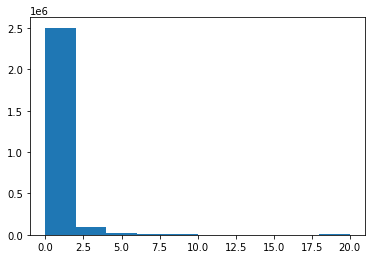

In [91]:
plt.hist(y_train)
#NOTE: Note outlier in training set (and not present in val set). 
#Reason why rmse worse in train than val set. 
#Also reason R2 better in train than val set (since normalised by the mean of each set in a sense) (so R2 for now more fairly shows the extend of overfitting)

(array([1.073085e+06, 3.660600e+04, 7.708000e+03, 2.845000e+03,
        1.345000e+03, 7.490000e+02, 5.110000e+02, 3.350000e+02,
        2.360000e+02, 1.120000e+03]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.],
       dtype=float16),
 <a list of 10 Patch objects>)

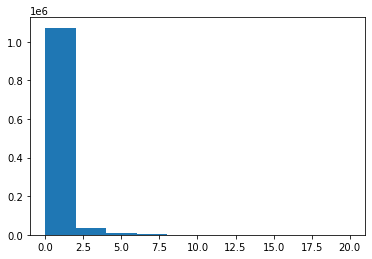

In [92]:
plt.hist(y_val)

In [123]:
print('Shape of X is ' + str(X_train.shape))
X_test.tail()

Shape of X is (2640305, 76)


,date_block_num,shop_id,item_id,item_category_id,price_mean_by_item_lag_1,price_mean_by_item_lag_2,price_mean_by_item_lag_3,price_mean_by_item_lag_6,price_mean_by_item_lag_12,sales_mean_by_item_lag_1,sales_mean_by_item_lag_2,sales_mean_by_item_lag_3,sales_mean_by_item_lag_6,sales_mean_by_item_lag_12,price_mean_by_shop_lag_1,price_mean_by_shop_lag_2,price_mean_by_shop_lag_3,price_mean_by_shop_lag_6,price_mean_by_shop_lag_12,sales_mean_by_shop_lag_1,sales_mean_by_shop_lag_2,sales_mean_by_shop_lag_3,sales_mean_by_shop_lag_6,sales_mean_by_shop_lag_12,price_mean_by_item_category_lag_1,price_mean_by_item_category_lag_2,price_mean_by_item_category_lag_3,price_mean_by_item_category_lag_6,price_mean_by_item_category_lag_12,sales_mean_by_item_category_lag_1,sales_mean_by_item_category_lag_2,sales_mean_by_item_category_lag_3,sales_mean_by_item_category_lag_6,sales_mean_by_item_category_lag_12,price_std_by_item_lag_1,price_median_by_item_lag_1,sales_std_by_item_lag_1,sales_median_by_item_lag_1,price_std_by_shop_lag_1,price_median_by_shop_lag_1,sales_std_by_shop_lag_1,sales_median_by_shop_lag_1,price_std_by_item_category_lag_1,price_median_by_item_category_lag_1,sales_std_by_item_category_lag_1,sales_median_by_item_category_lag_1,trend_price_mean_by_item_lag_1,trend_price_mean_by_item_lag_3,trend_price_mean_by_item_lag_6,trend_price_mean_by_item_lag_12,trend_sales_mean_by_item_lag_1,trend_sales_mean_by_item_lag_3,trend_sales_mean_by_item_lag_6,trend_sales_mean_by_item_lag_12,trend_price_mean_by_shop_lag_1,trend_price_mean_by_shop_lag_3,trend_price_mean_by_shop_lag_6,trend_price_mean_by_shop_lag_12,trend_sales_mean_by_shop_lag_1,trend_sales_mean_by_shop_lag_3,trend_sales_mean_by_shop_lag_6,trend_sales_mean_by_shop_lag_12,trend_price_mean_by_item_category_lag_1,trend_price_mean_by_item_category_lag_3,trend_price_mean_by_item_category_lag_6,trend_price_mean_by_item_category_lag_12,trend_sales_mean_by_item_category_lag_1,trend_sales_mean_by_item_category_lag_3,trend_sales_mean_by_item_category_lag_6,trend_sales_mean_by_item_category_lag_12,above_12m_avg_price_mean_by_item,above_12m_avg_sales_mean_by_item,above_12m_avg_price_mean_by_shop,above_12m_avg_sales_mean_by_shop,above_12m_avg_price_mean_by_item_category,above_12m_avg_sales_mean_by_item_category
11128045,34,46,12470,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,True,True,True,True,True
11128046,34,41,12470,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,True,True,True,True,True
11128047,34,44,12470,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,True,True,True,True,True
11128048,34,39,12470,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,True,True,True,True,True
11128049,34,45,12470,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,True,True,True,True,True


In [31]:
y_train.head()

2635    2.0
2636    0.0
2637    1.0
2638    0.0
2639    2.0
Name: item_cnt_month, dtype: float16

Model Specific feature set

In [64]:
#Remove categorical features unless encoded (e.g one-hot encoding) for basically any method other than a tree method (Linear Regresion, Neural Networks etc)
from sklearn.preprocessing import StandardScaler
LinRegFeaturesToDrop= ['date_block_num', 'shop_id', 'item_id', 'item_category_id']
scaler =  StandardScaler()
X_train_LinReg
X_train_LinReg = scaler.fit_transform(X_train.drop(LinRegFeaturesToDrop, axis = 1))
X_val_LinReg = scaler.transform(X_val.drop(LinRegFeaturesToDrop, axis = 1))
X_test_LinReg = scaler.transform(X_test.drop(LinRegFeaturesToDrop, axis = 1))


AttributeError: ignored

**Model Fit & Validate**

Linear Regression

In [83]:
import sklearn
from sklearn.linear_model import LinearRegression
X_train_model, X_val_model, X_test_model = X_train_LinReg, X_val_LinReg, X_test_LinReg
model = LinearRegression()
model.fit(X_train_LinReg, y_train)

y_pred_train, y_pred_val, y_pred_test =  model.predict(X_train_model).clip(0,20), model.predict(X_val_model).clip(0,20), model.predict(X_test_model).clip(0,20)
train_score, val_score = sklearn.metrics.r2_score(y_train, y_pred_train), sklearn.metrics.r2_score(y_val, y_pred_val)
train_rmse, val_rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_train, y_pred_train)), np.sqrt(sklearn.metrics.mean_squared_error(y_val, y_pred_val))
print('R^2 train_score is ' + str(train_score) + 'R^2 val_score is ' + str(val_score))
print('RMSE train_score is ' + str(train_rmse) + 'RMSE val_score is ' + str(val_rmse))

R^2 train_score is 0.03752469179591866R^2 val_score is 0.007223876332944079
RMSE train_score is 1.2295407310092477RMSE val_score is 1.0787019892120746


Feature Importance

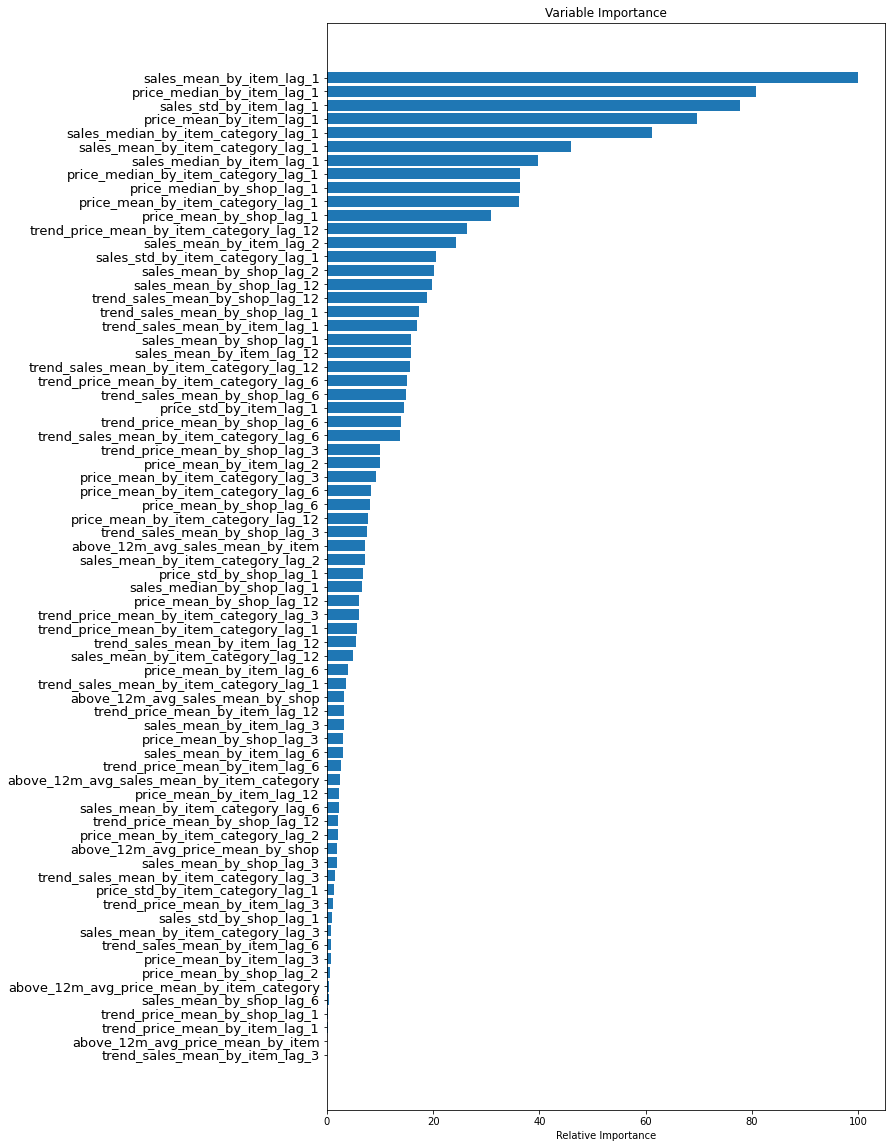

<Figure size 432x288 with 0 Axes>

In [79]:
feature_importance = np.abs(model.coef_)
# summarize feature importance
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10,20)) 
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.drop(LinRegFeaturesToDrop, axis = 1).columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.tick_params(axis='y', which='major', labelsize = 13)
plt.show()
plt.savefig('LinReg_feature_importance.png')

In [0]:
X_train_LinReg.columns

Submission Prep

In [0]:
#Folder to save models and predictions
import os
gdrive_repo_path = '/content/drive/My Drive/Colab Notebooks/Coursera_Data_Science_Competitions_Kaggle_project/Kag'
folder_to_save = '/models_and_predictions'
os.chdir(gdrive_repo_path + folder_to_save)

In [30]:
import pickle
model_name = 'LinRegv2'


submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": y_pred_test
})
submission.to_csv(model_name + '_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(y_pred_train, open(model_name + '_pred_train.pickle', 'wb'))
pickle.dump(y_pred_val, open(model_name + '_pred_val.pickle', 'wb'))
pickle.dump(y_pred_test, open(model_name + '_pred_test.pickle', 'wb'))

# save the model to disk
pickle.dump(model, open(model_name + '_model.sav', 'wb'))
 
 '''
# load the model from disk
loaded_model = pickle.load(open( model_name + '_model.sav', 'rb'))
print(result)
'''

IndentationError: ignored

In [0]:
submission.head()

,ID,item_cnt_month
0,0,0.620781
1,1,0.429811
2,2,0.416615
3,3,0.469035
4,4,0.434907


In [61]:
!pip install catboost
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import sklearn
import time 

LightGBM

In [19]:

# Prepare Categorical Variables
'''
categorical = []
for feature_engineered in features_engineered:
  categorical.append('above_12m_avg' + feature_engineered)

categorical.extend(['date_block_num','shop_id', 'item_id'])

def column_index(df, query_cols):
    indices = []
    for query_col in query_cols:
      index=df.columns.get_loc(query_col)
      indices.append(index)
    return indices
categorical_features_pos = column_index(X_train,categorical)
'''

start = time.time()
model = LGBMRegressor()
model.fit(X_train, y_train)
y_pred_train, y_pred_val, y_pred_test =  model.predict(X_train) , model.predict(X_val), model.predict(X_test).clip(0,20)
train_score, val_score = sklearn.metrics.r2_score(y_train, y_pred_train), sklearn.metrics.r2_score(y_val, y_pred_val)
train_rmse, val_rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_train, y_pred_train)), np.sqrt(sklearn.metrics.mean_squared_error(y_val, y_pred_val))
print('R^2 train_score is ' + str(train_score) + ' R^2 val_score is ' + str(val_score))
print('RMSE train_score is ' + str(train_rmse) + ' RMSE val_score is ' + str(val_rmse))
end = time.time()
print(end-start)


NameError: ignored

Feature Importance

In [0]:
import matplotlib.pyplot as plt
# Plot feature importance - Results Visualization
feature_importance = model.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.arange(feature_importance.shape[0])
pos = np.arange(sorted_idx.shape[0]) + .5
#pos = range(len(feature_importance))
plt.figure(figsize=(14,20)) 
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.tick_params(axis='y', which='major', labelsize = 13)
plt.show()
plt.savefig('gbt_feature_importance_v1.png')

Submission prep

In [0]:
#Folder to save models and predictions
import os
gdrive_repo_path = '/content/drive/My Drive/Colab Notebooks/Coursera_Data_Science_Competitions_Kaggle_project/Kag'
folder_to_save = '/models_and_predictions'
os.chdir(gdrive_repo_path + folder_to_save)

In [21]:
model_name = 'LGBMv2'

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": y_pred_test
})
submission.to_csv(model_name + '_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(y_pred_train, open(model_name + '_pred_train.pickle', 'wb'))
pickle.dump(y_pred_val, open(model_name + '_pred_val.pickle', 'wb'))
pickle.dump(y_pred_test, open(model_name + '_pred_test.pickle', 'wb'))

# save the model to disk
pickle.dump(model, open(model_name + '_model.sav', 'wb'))

 
# load the model from disk
'''
loaded_model = pickle.load(open(model_file_name, 'rb'))
'''

NameError: ignored

XGBoost - Gradient Boosting Tree

In [81]:
from xgboost import XGBRegressor
gbt = XGBRegressor()
gbt.fit(X_train, y_train)
model = gbt

y_pred_train, y_pred_val, y_pred_test =  model.predict(X_train).clip(0,20), model.predict(X_val).clip(0,20), model.predict(X_test).clip(0,20)
train_score, val_score = sklearn.metrics.r2_score(y_train, y_pred_train), sklearn.metrics.r2_score(y_val, y_pred_val)
train_rmse, val_rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_train, y_pred_train)), np.sqrt(sklearn.metrics.mean_squared_error(y_val, y_pred_val))
print('R^2 train_score is ' + str(train_score) + 'R^2 val_score is ' + str(val_score))
print('RMSE train_score is ' + str(train_rmse) + 'RMSE val_score is ' + str(val_rmse))

[20:59:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R^2 train_score is 0.2597516851927857R^2 val_score is 0.193802720665587
RMSE train_score is 1.0782931RMSE val_score is 0.9720677


Feature Importance

In [84]:
import matplotlib.pyplot as plt
# Plot feature importance - Results Visualization
feature_importance = model.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(14,20)) 
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.tick_params(axis='y', which='major', labelsize = 13)
plt.show()
plt.savefig('gbt_feature_importance.png')

AttributeError: ignored

Sumbission prep

In [0]:
model_name = 'XGBv2'

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": y_pred_test
})
submission.to_csv(model_name + '_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(y_pred_train, open(model_name + '_pred_train.pickle', 'wb'))
pickle.dump(y_pred_val, open(model_name + '_pred_val.pickle', 'wb'))
pickle.dump(y_pred_test, open(model_name + '_pred_test.pickle', 'wb'))

# save the model to disk
pickle.dump(model, open(model_name + '_model.sav', 'wb'))

 
# load the model from disk
'''
loaded_model = pickle.load(open(model_file_name, 'rb'))
'''

"\nloaded_model = pickle.load(open(model_file_name, 'rb'))\nresult = loaded_model.score(X_test, Y_test)\nprint(result)\n"

EDA

In [0]:
df1 = data.describe(include = 'all')
df1.loc['dtype'] = data.dtypes
df1.loc['size'] = len(data)
df1.loc['% Null_count'] = data.isnull().mean()
df1

**Data Cleaning**

In [0]:
#impute any potential missing values or deal with outliers

Feature Engineering

In [0]:
# To construct month, year feature from data
# count of days in a month
# time components of item_price and item_cnt (value at t-1, t-2, t-3, t-6, t-12 maybe)
# rate of change of item_cnt (between t-1 and t-2 e.g.), 
# statistics on item_price and item_cnt - mean, std, range, mode, skew?


In [0]:
#Create a distinct day, month, year column
'''
df['date'] = pd.to_datetime(df['date'], format = "%d.%m.%Y")
df['year'], df['month'], features['day'] = df['date'].dt.year, df['date'].dt.month, df['date'].dt.day
df.head()
'''
#also get day count (days in a month)